In [109]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns

In [110]:
# 加载数据
train = pd.read_csv('train_weather.csv', index_col='Unnamed: 0')
test = pd.read_csv('test_weather.csv', index_col='Unnamed: 0')
submit = pd.read_csv('submit_result.csv', index_col='Unnamed: 0')

In [112]:
# 删除训练集中的空值行
train = train.dropna(subset=['RainTomorrow'])

# 再次检查数据集的信息
train.info(), test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 113754 entries, 0 to 113753
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           113754 non-null  object 
 1   Location       113754 non-null  object 
 2   MinTemp        113229 non-null  float64
 3   MaxTemp        113486 non-null  float64
 4   Rainfall       112572 non-null  float64
 5   Evaporation    64963 non-null   float64
 6   Sunshine       59409 non-null   float64
 7   WindGustDir    106296 non-null  object 
 8   WindGustSpeed  106348 non-null  float64
 9   WindDir9am     105718 non-null  object 
 10  WindDir3pm     110731 non-null  object 
 11  WindSpeed9am   112671 non-null  float64
 12  WindSpeed3pm   111645 non-null  float64
 13  Humidity9am    112334 non-null  float64
 14  Humidity3pm    110841 non-null  float64
 15  Pressure9am    102497 non-null  float64
 16  Pressure3pm    102529 non-null  float64
 17  Cloud9am       70713 non-null

(None, None)

In [113]:
# 找出 Cloud3pm 列中值为 9 的行的索引
invalid_rows_test = test[test['Cloud9am'] == 9].index
# 删除找到的行
test.drop(invalid_rows_test, inplace=True)
invalid_rows_train = train[train['Cloud3pm'] == 9].index

# 删除找到的行
train.drop(invalid_rows_train, inplace=True)

submit.drop(invalid_rows_test, inplace=True)

In [114]:
# 更改索引为日期
train['Date'] = pd.to_datetime(train['Date'])  # 将日期列转换为 datetime 类型
train.set_index('Date', inplace=True)  # 设置日期列为索引
test['Date'] = pd.to_datetime(test['Date'])  # 将日期列转换为 datetime 类型
test.set_index('Date', inplace=True)  # 设置日期列为索引

In [115]:
# 离散型数据处理缺失值
cate_columns = ['RainTomorrow', 'WindDir3pm', 'WindDir9am', 'WindGustDir']

si = SimpleImputer(missing_values=np.nan,strategy="most_frequent") # 使用众数填充缺失值

# 在训练集上进行fit和transform
train[cate_columns] = si.fit_transform(train[cate_columns])

In [116]:
# 测试集
cate_columns = ['WindDir3pm', 'WindDir9am', 'WindGustDir']

si = SimpleImputer(missing_values=np.nan,strategy="most_frequent") # 使用众数填充缺失值

test[cate_columns] = si.fit_transform(test[cate_columns])

In [117]:
# 连续型数据处理缺失值
# 连续型数据是指可以取到某个区间内的任意值的数据，通常以实数表示。

cate_columns = ['RainTomorrow', 'WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']

columns = train.columns.to_list()
for col in cate_columns:
    columns.remove(col)
impmean = SimpleImputer(missing_values=np.nan,strategy = "mean")
train[columns] = impmean.fit_transform(train[columns])

In [118]:
# 测试集

cate_columns = ['WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']

columns = test.columns.to_list()
for col in cate_columns:
    columns.remove(col)
    
impmean = SimpleImputer(missing_values=np.nan,strategy = "mean")
# 同理

test[columns] = impmean.fit_transform(test[columns])

In [119]:
# 查看数据处理后的效果
train.isnull().sum(), test.isnull().sum()

(Location         0
 MinTemp          0
 MaxTemp          0
 Rainfall         0
 Evaporation      0
 Sunshine         0
 WindGustDir      0
 WindGustSpeed    0
 WindDir9am       0
 WindDir3pm       0
 WindSpeed9am     0
 WindSpeed3pm     0
 Humidity9am      0
 Humidity3pm      0
 Pressure9am      0
 Pressure3pm      0
 Cloud9am         0
 Cloud3pm         0
 Temp9am          0
 Temp3pm          0
 RainTomorrow     0
 dtype: int64,
 Location         0
 MinTemp          0
 MaxTemp          0
 Rainfall         0
 Evaporation      0
 Sunshine         0
 WindGustDir      0
 WindGustSpeed    0
 WindDir9am       0
 WindDir3pm       0
 WindSpeed9am     0
 WindSpeed3pm     0
 Humidity9am      0
 Humidity3pm      0
 Pressure9am      0
 Pressure3pm      0
 Cloud9am         0
 Cloud3pm         0
 Temp9am          0
 Temp3pm          0
 dtype: int64)

In [120]:
# 离散型数据标准化

cate_columns = ['RainTomorrow', 'WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']
lb = LabelEncoder()
train[cate_columns] = train[cate_columns].apply(lambda x: lb.fit_transform(x.astype(str)))

In [123]:
# 测试集

cate_columns = ['WindDir3pm', 'WindDir9am', 'WindGustDir', 'Location']
lb = LabelEncoder()
test[cate_columns] = test[cate_columns].apply(lambda x: lb.fit_transform(x.astype(str)))

<Axes: >

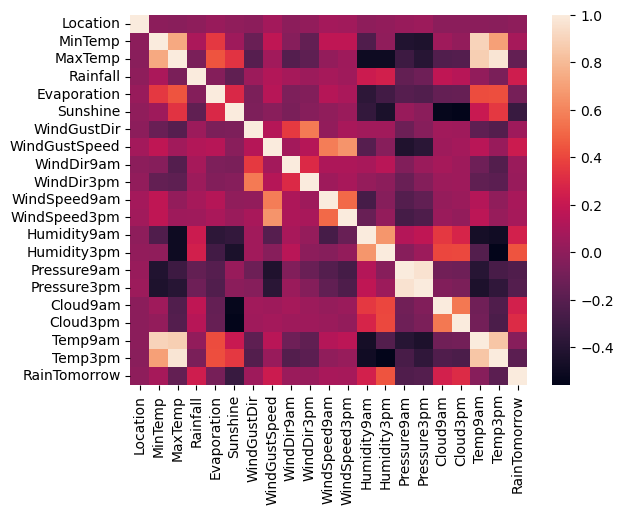

In [124]:
# 特征相关性

sns.heatmap(train.corr())

In [125]:
# 切分训练集和测试集

x = train.drop('RainTomorrow', axis=1)
y = train['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=73)

In [126]:
# 构建模型

model = XGBClassifier(random_state=73)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=73, ...)

In [127]:
y_pred = model.predict(x_test)

In [128]:
from sklearn.metrics import accuracy_score

# 假设 y_test 是测试集的真实标签
accuracy = accuracy_score(y_test, y_pred)
print(f"模型的准确率：{accuracy:.4f}")

模型的准确率：0.8610


In [129]:
# 模型调参
param_grid = {
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [50, 100, 200],
    "gamma": [0, 0.1, 0.2, 0.5],
    "min_child_weight": [1, 3, 5]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [130]:
# 进行网格搜索和交叉验证
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=73, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2, 0.5],
                         'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [131]:
# 最佳参数和最高准确率
# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 使用最佳参数的模型进行预测
best_model = grid_search.best_estimator_

result = best_model.predict(test)

最佳参数: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200}


In [132]:
# 计算结果集并保存

result = model.predict(test)
# 保存预测结果并保存为文件，这里要注意因为测试集存在非法值，有一部分数据被删除，所以submit 中对应索引的行也要被删除
submit['RainTomorrow'] = result
submit.to_csv('submission.csv')